### by using a optima HyperParameter Tuning

1. number of hidden layers
2. neurons per layers
3. number of epochs 
4. optimizer
5. learning rate
6. Batch size 
7. Dropout rate
8. weight decay(lambda)

### Optuna HyperParameter Tuning Workflow

1. **Define Objective Function**: Create an objective function that Optuna will optimize.
2. **Search Space**: Define the hyperparameter search space for Optuna to explore.
3. **Model Initialization**: Initialize the model with the hyperparameters sampled by Optuna.
4. **Parameter Initialization**: Set up the parameters for training the model.
5. **Training Loop**: Implement the training loop to train the model.
6. **Evaluation**: Evaluate the model's performance and return the metric to be optimized.

In [22]:
import torch
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("cuDNN Version:", torch.backends.cudnn.version())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


PyTorch Version: 2.5.1
CUDA Available: True
CUDA Version: 12.4
cuDNN Version: 90100
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn

In [24]:
torch.manual_seed(42)

In [25]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
df=pd.read_csv('fmnist_small.csv')

In [27]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [28]:
df.shape

(6000, 785)

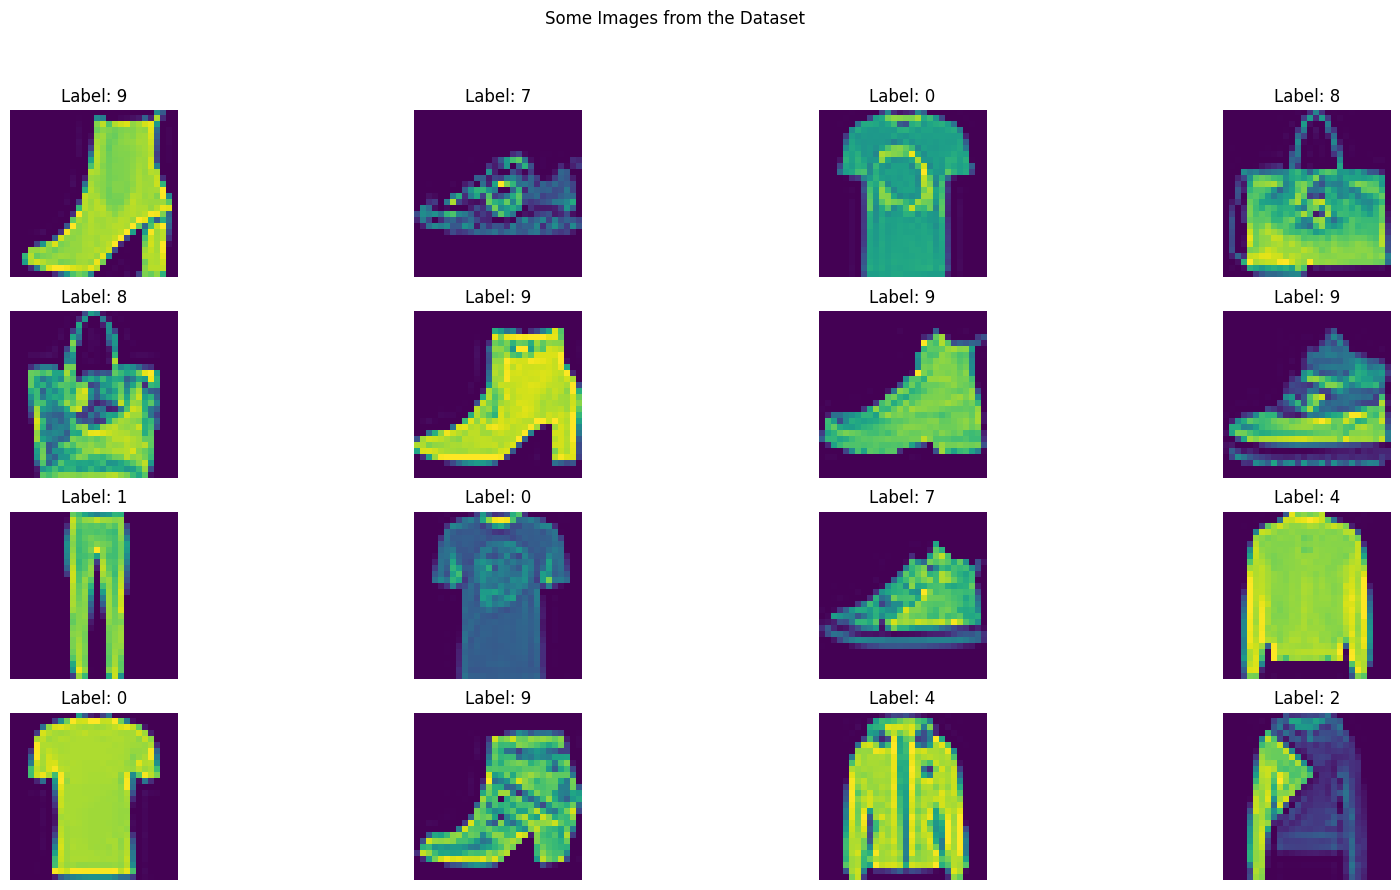

In [29]:
fig,axes=plt.subplots(4,4,figsize=(20,10))
fig.suptitle('Some Images from the Dataset')
for i ,ax in enumerate(axes.flat):
    img=df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {df.iloc[i,0]}')

In [30]:
# tarin test split
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
x_train = x_train/255.0
X_test = x_test/255.0

In [33]:
class CustomDataset(Dataset):
    
    def __init__(self,features,labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [34]:
train_dataset = CustomDataset(x_train, y_train)

In [35]:
test_dataset = CustomDataset(x_test, y_test)

In [36]:
class MyNN(nn.Module):

    def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layer,dropout_rate):
        super().__init__()
        
        layers=[]

        for i in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim,neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim=neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer,output_dim))
        
        self.model=nn.Sequential(*layers) # * is used to unpack the list of layers and pass them as arguments to nn.Sequential  
    def forward(self,x):
        return self.model(x)

In [37]:
import torch.optim as optim

In [38]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [39]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-02-05 22:28:11,120] A new study created in memory with name: no-name-3e5d0788-b45e-4739-a229-a8c4dc766860


In [ ]:
study.optimize(objective, n_trials=10)

In [20]:
study.best_value

0.76

In [ ]:
study.best_params

{'num_hidden_layers': 2,
 'neurons_per_layer': 56,
 'epochs': 30,
 'learning_rate': 0.006047148872977049,
 'dropout_rate': 0.4,
 'batch_size': 128,
 'optimizer': 'Adam',
 'weight_decay': 1.2931380920490417e-05}